## 2.&nbsp; Channel -- with joint prior


In [ ]:
import numpy as np
from scipy.special import rel_entr
import matplotlib.pyplot as plt

In [ ]:
def M_channel(f0, f1):
  Ch = [[1-f0, f0], [f1, 1-f1]]
  return np.array(Ch)

In [ ]:
q_o = [0.5, 0.5]
alpha = np.array([0.8, 0.2])
x = np.random.dirichlet(alpha)
q_c = np.array([x[0]/2, x[1]/2, x[0]/2, x[1]/2])
q_c = np.array([0.498, 0.002, 0.498, 0.002])

In [ ]:
MIdata = []
MCdata = []
Hdata = []

f0 = 0.001
f1 = f0
H = []
sumKL = []
MI = []
Ch = M_channel(f0, f1)
X = np.linspace(0.01, 0.99, 1000)
for x in X:
  p_in = np.array([x, 1-x])
  H.append(-np.dot(p_in, np.log(p_in)))
  p_y = Ch.T@p_in
  p_xy = Ch*p_in[:, np.newaxis]

  q_c_margx = np.sum(np.reshape(q_c, (2, 2)), axis = 1)
  Hdata.append(-np.dot(p_in, np.log(p_in)))
  MI.append(np.sum(rel_entr(p_xy.flatten(), np.outer(p_in, p_y).flatten())))
  sumKL.append(np.sum(rel_entr(p_in, q_o))+np.sum(rel_entr(np.outer(p_in, p_y).flatten(), q_c))-np.sum(rel_entr(p_in, q_c_margx)))

sumKL = np.array(sumKL)
MI = np.array(MI)
am = np.argmax(MI)

In [ ]:
d_KL = (sumKL[am+1:]-sumKL[am:-1])/(MI[am+1:]-MI[am:-1])
dd_KL = (sumKL[am:-1]/MI[am:-1])

In [ ]:
jj = np.where(np.abs(d_KL-dd_KL) < 0.001)[0][0]
x_ = MI[am+jj]
y_ = sumKL[am+jj]

In [ ]:
p_in = np.array([0.0001, 1-0.0001])
p_y = Ch.T@p_in
p_xy = Ch*p_in[:, np.newaxis]
q_c_margx = np.sum(np.reshape(q_c, (2, 2)), axis = 1)
fp = np.sum(rel_entr(p_in, q_o))+np.sum(rel_entr(np.outer(p_in, p_y).flatten(), q_c))-np.sum(rel_entr(p_in, q_c_margx))

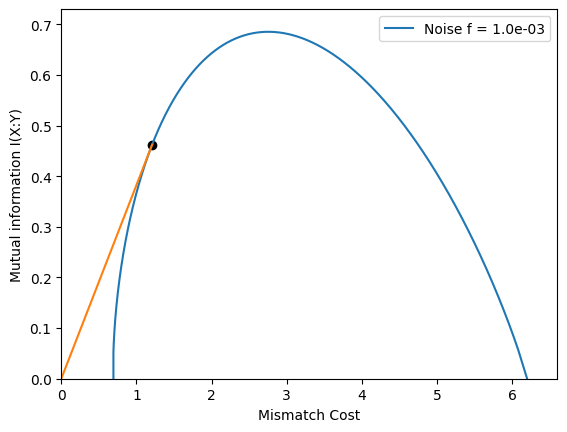

In [ ]:
h = np.append(np.append([0], MI), [0])
hh = np.append(np.append( fp, MI+sumKL),  (MI+sumKL)[-1])
plt.plot(hh, h, label = 'Noise f = %0.1e'%f0)
plt.xlim((0, 6.6))
plt.ylim((0, 0.73))
plt.plot(np.linspace(0, (sumKL+MI)[am+jj], 100), np.linspace(0, x_, 100))
plt.scatter(x = (sumKL+MI)[am+jj], y = x_, c = 'black')
plt.ylabel("Mutual information I(X:Y)")
plt.xlabel("Mismatch Cost")
plt.legend()

In [ ]:
MIdata = []
MCdata = []
Hdata = []

#w = 0.49
#q_c = [w, (1-2*w)/2, w, (1-2*w)/2]
for f in [0.000001, 0.001, 0.01]:
  H = []
  sumKL = []
  MI = []
  Ch = M_channel(f, f)

  for x in np.linspace(0.01, 0.99, 40):
    p_in = np.array([x, 1-x])
    H.append(-np.dot(p_in, np.log(p_in)))
    p_y = Ch.T@p_in
    p_xy = Ch*p_in[:, np.newaxis]
    q_c_margx = np.sum(np.reshape(q_c, (2, 2)), axis = 1)
    MI.append(np.sum(rel_entr(p_xy.flatten(), np.outer(p_in, p_y).flatten())))
    sumKL.append(np.sum(rel_entr(p_in, q_o))+np.sum(rel_entr(np.outer(p_in, p_y).flatten(), q_c))-np.sum(rel_entr(p_in, q_c_margx)))

  MIdata.append(MI)
  MCdata.append(np.array(MI)+np.array(sumKL))

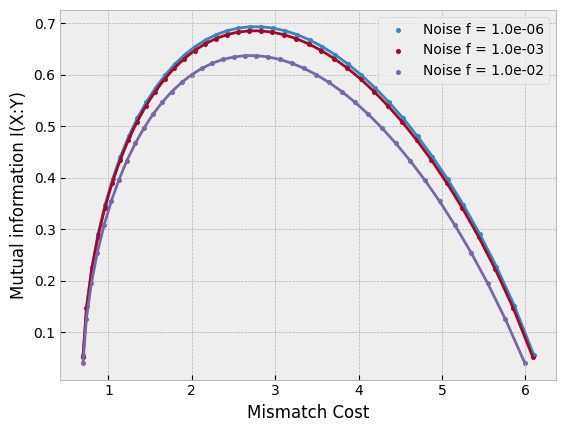

In [ ]:
i = 0
plt.style.use('bmh')
for f in [0.000001, 0.001, 0.01]:
  plt.scatter(MCdata[i], MIdata[i], label = 'Noise f = %0.1e'%f, marker = 'x', s = 6)
  plt.plot(MCdata[i], MIdata[i])
  i+=1
plt.yscale('linear')
plt.ylabel("Mutual information I(X:Y)")
plt.xlabel("Mismatch Cost")
plt.legend()

## 0.&nbsp;

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import dirichlet
from scipy.sparse import csr_matrix, lil_matrix
from scipy.stats import entropy as KL
from scipy.special import rel_entr

In [ ]:
## Syndrome Decoding Algorithm: For (n,k) linear encoder
k = 4 #size of the input bit string
v1 = 2**np.arange(k)

I = np.identity(k)
P = np.array([[1, 1, 0, 1], [1, 0, 1, 1], [0, 1, 1, 1], [1, 1, 1, 1]]) #Parity matrix

## 1.&nbsp; Encoder algorithmic process and state space

In [ ]:
be = np.arange(2)+np.random.uniform(size = 2) #For unique hashing

def encoding_algorithm(x, n):
  for c in range(1, n-k+1):
    x[i+k-1] = np.dot(P[i-1], x[:k])%2
  return x

def update(x, i, hvals, xlist, ilist):
  xlist.append(x)
  ilist.append(i)
  hvals.append(np.dot(2**np.arange(len(x)), x)*be[0]+i*be[1])
  return hvals, xlist, ilist

def encoding_algorithm_sim(x, n):
  i = 0
  xlist = [x]
  ilist = [i]
  hvals = [np.dot(2**np.arange(len(x)), x)*be[0]+i*be[1]]
  for i in range(1, n-k+1):
    x[i+k-1] = np.dot(P[i-1], x[:k])%2
    hvals, xlist, ilist = update(x, i, hvals, xlist, ilist)
  return hvals


In [ ]:
ELN = []
COLMASK = []
AE2 = []
AE3 = []
for n in range(k+1, k+5):
  v2 = 2**np.arange(n)
  H = np.append(I, P[:n-k], axis = 0)
  messages = [(((i & (1 << np.arange(k)))) > 0).astype(int) for i in range(2**k)]
  encoded_messages = [H@x%2 for x in messages]
  ValidCodewords = np.array([np.dot(v2, m) for m in encoded_messages], dtype = int)


  #CREATING THE GRAPH
  sze = (2**n)*(n-k+1)
  uniquehash = np.zeros(sze)

  #Hashing
  u = 0
  for x_in in range(2**n): #input bits
    for t in range(n-k+1):
      uniquehash[u] = x_in*be[0]+t*be[1]
      u+=1

  Ae = lil_matrix((sze, sze))
  # Convert 'uniquehash' to a dictionary for faster lookup
  uniquehash_dict = {hash_val: idx for idx, hash_val in enumerate(uniquehash)}


  for i in range(2**n):
    x = ((i & (1 << np.arange(n))) > 0).astype(int)
    hvals = encoding_algorithm_sim(x, n)
    L = len(hvals)
    for u in range(L):
      n1 = uniquehash_dict.get(hvals[u])
      if u < L-1:
        n2 = uniquehash_dict.get(hvals[u+1])
      else:
        n2 = n1
      Ae[(n1, n2)]=1

  Ae_csr = Ae.tocsr()
  row_mask = np.array(Ae.sum(axis=1) == 1).flatten()  #Compute the boolean mask for rows/columns with sum == 1
  indices = np.where(row_mask)[0]  #Convert the boolean mask to indices
  Ae2 = Ae_csr[indices, :][:, indices].toarray()   #Use the indices to create the submatrix and convert to dense array

  eln = np.shape(Ae2)[0]
  col_mask_e = np.array(Ae2.sum(axis=0) == 0).flatten() #indices of initial states

  Ae3 = lil_matrix((2**n, 2**n))
  for n1 in range(2**n):
    x = ((n1 & (1 << np.arange(n))) > 0).astype(int)
    x = encoding_algorithm(x[:n], n)
    n2 = np.dot(v2, x)
    Ae3[(n1, n2)] = 1

  #SAVING FILES

  ELN.append(eln)
  AE2.append(Ae2)
  AE3.append(Ae3)
  COLMASK.append(col_mask_e)

  print(n)

5
6
7
8


In [ ]:
print(ELN)

[48, 112, 240, 496]


In [ ]:
MMC = []
i = 0
for n in range(k+1, k+5):
  MC = []
  eln = ELN[i]
  Ae2 = AE2[i]
  Ae3 = AE3[i]
  col_mask_e = COLMASK[i]
  i += 1
  alpha = 0.5
  #q0_e = np.random.dirichlet(alpha*np.ones(eln))   #random prior
  q0_e = 1/eln*np.ones(eln)                       #uniform prior
  q1 = Ae2.T@q0_e
  for p in np.linspace(0.3, 0.8, 5):
    x = [p, 1-p]
    p_in = x
    for h in range(k-1):
      p_in = np.outer(p_in, x).flatten(order = 'F')
    p_tnin_encoder = (1/2**(n-k))*np.ones(2**(n-k))


    PMCi = 0
    p0 = np.zeros(eln)

    p_joint = Ae3.T@(np.outer(p_in, p_tnin_encoder).flatten(order = 'F'))
    p_marg_nin = np.sum(p_joint.reshape((2**k, 2**(n-k))), axis = 0)
    print(np.sum(col_mask_e))
    p0[col_mask_e] = np.outer(p_in, p_marg_nin).flatten(order = 'F')

    for r in range(n-k+1):
      p1 = Ae2.T@p0
      PMCi+=np.sum(rel_entr(p0, q0_e))-np.sum(rel_entr(p1, q1))
      p0 = p1

    MC.append(PMCi)
  MMC.append(np.array(MC).T)

32
32
32
32
32
64
64
64
64
64
128
128
128
128
128
256
256
256
256
256


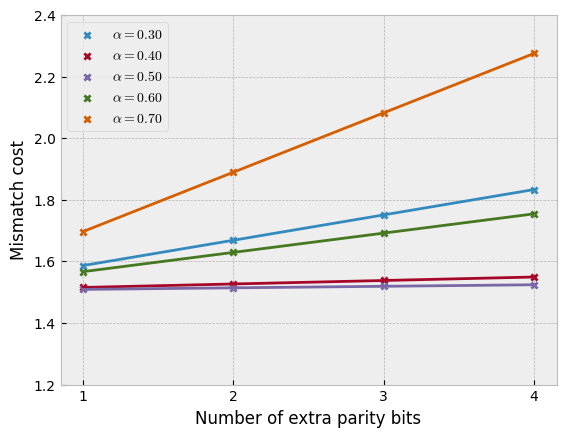

In [ ]:
plt.style.use('bmh')
i = 0
for p_in in [0.3, 0.4, 0.5, 0.6, 0.7]:
  plt.scatter(range(1, 5), np.array(MMC).T[i], marker='x', s = 20, label = r'$\alpha = %0.2f$'%(p_in))
  plt.plot(range(1, 5), np.array(MMC).T[i])
  i+=1

plt.ylim(1.2, 2.4)
plt.xticks(range(1, 5))
plt.ticklabel_format(axis='y', style='plain')
plt.xlabel('Number of extra parity bits')
plt.ylabel('Mismatch cost')
plt.legend()

## 2.&nbsp; Decoder algorithmic process and state space

In [ ]:
def M(f, n):
  M_f =  np.zeros((2**(n), 2**(n)))
  for s1 in range(2**(n)):
    x = np.array((((s1 & (1 << np.arange(n)))) > 0).astype(int))
    for noise in range(2**(n)):
      noise = np.array((((noise & (1 << np.arange(n)))) > 0).astype(int))
      s2 = np.dot(2**np.arange(n), (x+noise)%2)
      M_f[(s1, s2)] = np.prod(f**noise)*np.prod((1-f)**(1-noise))
  return M_f


In [ ]:
#CONSTRUCTION OF LOOK UP TABLE for different encoding lenghts but same noise f = 0.01

f = 0.001
Tables = []
for n in range(k+1, k+5):
  G = np.append(P[:n-k].T, np.identity(n-k), axis = 0) #Syndrome Matrix

  Table = dict()
  E_ = np.arange(0, 2**n)
  E = np.array([(((v & (1 << np.arange(n)))) > 0).astype(int) for v in E_])
  S = [G.T@y%2 for y in E]
  i = 0
  for e in E:
    if tuple(S[i]) in Table.keys():
      e = np.array(Table[tuple(S[i])])
      if np.prod((f**e)*(1-f)**(1-e)) < np.prod((f**E[i])*(1-f)**(1-E[i])):
        Table[tuple(S[i])] = E[i]
    else:
      Table[tuple(S[i])] = E[i]
    i+=1
  Tables.append(Table)

#with open(LookUpTable_path, 'wb') as fi:
    #pickle.dump(Tables, fi)

In [ ]:
DLN = []
AD2 = []
AD3 = []
COLMASKD = []

In [ ]:
bd = np.arange(4)+np.random.uniform(size = 4) #For unique hashing

#with open(LookUpTable_path, 'rb') as fi:
  #Tables = pickle.load(fi)

for n in range(k+1, k+5):
  v2 = 2**np.arange(n)
  Table = Tables[n-k-1]
  G = np.append(P[:n-k].T, np.identity(n-k), axis = 0) #Syndrome Matrix

  szd = (2**n) * (2**(n-k)) * (2**n) * 4
  uniquehash = np.zeros(szd, dtype=np.int64)

  # Compute the hash values using broadcasting
  hash_values = (np.arange(2**n)[:, None, None, None] * bd[0] +
                np.arange(2**(n-k))[None, :, None, None] * bd[1] +
                np.arange(2**n)[None, None, :, None] * bd[2] +
                np.arange(4)[None, None, None, :] * bd[3])

  uniquehash = hash_values.flatten()

  Ad = lil_matrix((szd, szd))

  # Convert 'uniquehash' to a dictionary for faster lookup
  uniquehash_dict = {hash_val: idx for idx, hash_val in enumerate(uniquehash)}

  # Precompute the arrays that don't change within the inner loops
  arrays_n = [((i & (1 << np.arange(n))) > 0).astype(int) for i in range(2**n)]
  arrays_n_k = [((j & (1 << np.arange(n-k))) > 0).astype(int) for j in range(2**(n-k))]


  # Main loop
  for i, y in enumerate(arrays_n):
      print('Loop', i)
      for s in arrays_n_k:
          for e in arrays_n:
              s0 = s
              y0 = y
              e0 = e

              cl = 0
              hvals= [(np.dot(v2,y0))*bd[0]+(np.dot(2**(np.arange(n-k)),s0))*bd[1]+(np.dot(v2,e0))*bd[2]+cl*bd[3]]

              s0 = G.T@y0%2 #Calculating syndrome
              cl = 1
              hvals.append((np.dot(v2,y0))*bd[0]+(np.dot(2**(np.arange(n-k)),s0))*bd[1]+(np.dot(v2,e0))*bd[2]+cl*bd[3])

              e0 = Table[tuple(s0)] #look-up table
              cl = 2
              hvals.append((np.dot(v2,y0))*bd[0]+(np.dot(2**(np.arange(n-k)),s0))*bd[1]+(np.dot(v2,e0))*bd[2]+cl*bd[3])

              y0 = (y0+e0)%2 #estimated output
              cl = 3
              hvals.append((np.dot(v2,y0))*bd[0]+(np.dot(2**(np.arange(n-k)),s0))*bd[1]+(np.dot(v2,e0))*bd[2]+cl*bd[3])
              #hvals = SYndromeDecoder_est(s, e, y)
              L = len(hvals)

              for u in range(L):
                  n1 = uniquehash_dict.get(hvals[u])
                  #if n1 is None:
                      #print('error')
                      #continue

                  if u < L - 1:
                      n2 = uniquehash_dict.get(hvals[u + 1])
                      #if n2 is None:
                          #print('error')
                          #continue
                  else:
                      n2 = n1

                  Ad[(n1, n2)] = 1

  Ad_csr = Ad.tocsr()
  row_mask = np.array(Ad.sum(axis=1) == 1).flatten()  #Compute the boolean mask for rows/columns with sum == 1
  indices = np.where(row_mask)[0]  #Convert the boolean mask to indices
  Ad2 = Ad_csr[indices, :][:, indices]  #Use the indices to create the submatrix and convert to dense array
  del Ad_csr
  del Ad
  #col_mask_d = np.asarray(Ad_csr.sum(axis=0) == 0).flatten() #indices of initial states
  #dln = len(Ad2)
  dln = Ad2.shape[0]
  col_mask_d = (Ad2.getnnz(axis=0) == 0).astype(bool)
  COLMASKD.append(col_mask_d)
  DLN.append(dln)
  AD2.append(Ad2)

  print(n)

Loop 0
Loop 1
Loop 2
Loop 3
Loop 4
Loop 5
Loop 6
Loop 7
Loop 8
Loop 9
Loop 10
Loop 11
Loop 12
Loop 13
Loop 14
Loop 15
Loop 16
Loop 17
Loop 18
Loop 19
Loop 20
Loop 21
Loop 22
Loop 23
Loop 24
Loop 25
Loop 26
Loop 27
Loop 28
Loop 29
Loop 30
Loop 31
5
Loop 0
Loop 1
Loop 2
Loop 3
Loop 4
Loop 5
Loop 6
Loop 7
Loop 8
Loop 9
Loop 10
Loop 11
Loop 12
Loop 13
Loop 14
Loop 15
Loop 16
Loop 17
Loop 18
Loop 19
Loop 20
Loop 21
Loop 22
Loop 23
Loop 24
Loop 25
Loop 26
Loop 27
Loop 28
Loop 29
Loop 30
Loop 31
Loop 32
Loop 33
Loop 34
Loop 35
Loop 36
Loop 37
Loop 38
Loop 39
Loop 40
Loop 41
Loop 42
Loop 43
Loop 44
Loop 45
Loop 46
Loop 47
Loop 48
Loop 49
Loop 50
Loop 51
Loop 52
Loop 53
Loop 54
Loop 55
Loop 56
Loop 57
Loop 58
Loop 59
Loop 60
Loop 61
Loop 62
Loop 63
6
Loop 0
Loop 1
Loop 2
Loop 3
Loop 4
Loop 5
Loop 6
Loop 7
Loop 8
Loop 9
Loop 10
Loop 11
Loop 12
Loop 13
Loop 14
Loop 15
Loop 16
Loop 17
Loop 18
Loop 19
Loop 20
Loop 21
Loop 22
Loop 23
Loop 24
Loop 25
Loop 26
Loop 27
Loop 28
Loop 29
Loop 30
Loop 31
Lo

In [ ]:
AD3 = []
for n in range(k+1, k+5):
  G = np.append(P[:n-k].T, np.identity(n-k), axis = 0)
  Table = Tables[n-k-1]
  state_len = n+n+n-k
  Ad3 = lil_matrix((2**state_len, 2**state_len))
  for n1 in range(2**state_len):
    x = ((n1 & (1 << np.arange(state_len))) > 0).astype(int)
    x[n:n+n-k] = G.T@x[:n]%2 #Calculating syndrome [Codeline 1: Matrix Multiplication]
    x[n+n-k:] = Table[tuple(x[n:n+n-k])] #look-up table [Codeline 2: Searching an element in the table]
    x[:n] = (np.array(x[:n])+np.array(x[n+n-k:]))%2 #estimated output [Codeline 3]
    n2 = np.dot(2**np.arange(state_len), x)
    #print(n1, n2)
    Ad3[(n1, n2)] = 1
  AD3.append(Ad3)

In [ ]:
MMCD = []

In [ ]:
#Doesn't matter
#PRIOR for decoder IS DEFINED HERE!

i = 0
f = 0.001
MMCD = []

for n in range(k+1, k+5):
  v2 = 2**np.arange(n)
  H = np.append(I, P[:n-k], axis = 0)
  messages = [(((i & (1 << np.arange(k)))) > 0).astype(int) for i in range(2**k)]
  encoded_messages = [H@x%2 for x in messages]
  ValidCodewords = np.array([np.dot(v2, m) for m in encoded_messages], dtype = int)
  nin_size = n+n-k
  M_f = M(f, n)
  MCd = []
  dln = DLN[i]
  Ad2 = AD2[i]
  Ad3 = AD3[i]
  col_mask_d = COLMASKD[i]
  i += 1
  #alpha = 0.5
  #q0_e = np.random.dirichlet(alpha*np.ones(eln))   #random prior
  q0_d = 1/dln*np.ones(dln)                       #uniform prior
  q1 = Ad2.T@q0_d
  for p in [0.3, 0.4, 0.5, 0.6, 0.7]:
    x = [p, 1-p]
    p_in = x
    for h in range(k-1):
      p_in = np.outer(p_in, x).flatten(order = 'F')
    p_in_encoder = p_in
    p_in_channel_messages = np.zeros(2**n)
    p_in_channel_messages[ValidCodewords] = p_in
    p_out_channel_messages = M_f.T@p_in_channel_messages
    p_tnin_decoder = (1/2**nin_size)*np.ones(2**nin_size)


    PMCdi = 0
    p0 = np.zeros(dln)
    p_joint = Ad3.T@np.outer(p_out_channel_messages, p_tnin_decoder).flatten(order = 'F')
    p_marg_nin = np.sum(p_joint.reshape((2**n, 2**(n+n-k))), axis = 0)
    p0[col_mask_d] = np.outer(p_out_channel_messages, p_marg_nin).flatten(order = 'F')

    for r in range(3):
      p1 = Ad2.T@p0
      PMCdi += np.sum(rel_entr(p0, q0_d))-np.sum(rel_entr(p1, q1))
      p0 = p1

    MCd.append(PMCdi)

  MMCD.append(np.array(MCd).T)

Text(0, 0.5, 'Mismatch Cost')

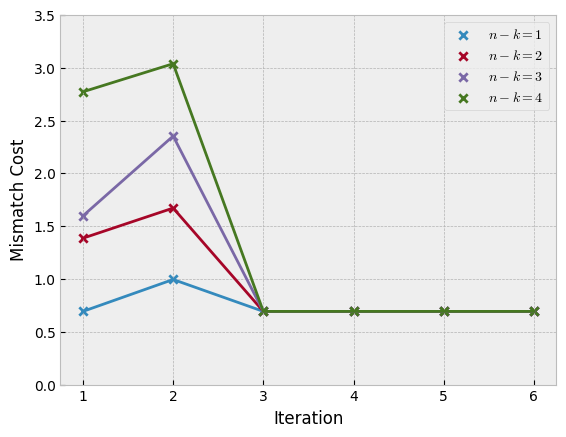

In [ ]:
p_in = [0.3, 0.4, 0.5, 0.6, 0.7]
for i in np.arange(1, 5):
  plt.scatter(range(1, 7), MCd[i-1], marker = 'x', label = r'$n-k = %d$'%(i))
  plt.plot(range(1, 7), MCd[i-1])
plt.legend()
plt.ylim(0, 3.5)
plt.xlabel('Iteration')
plt.ylabel('Mismatch Cost')

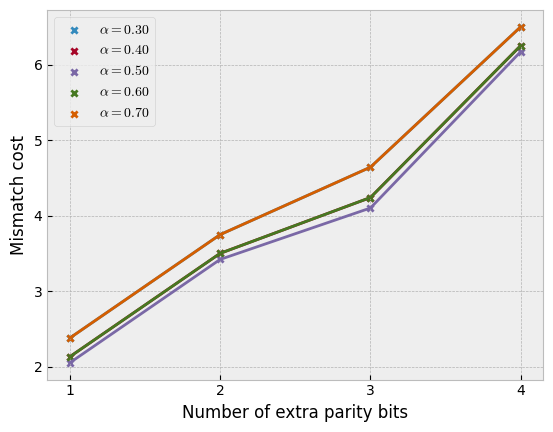

In [ ]:
p_in = [0.3, 0.4, 0.5, 0.6, 0.7]
i = 0
for p_in in [0.3, 0.4, 0.5, 0.6, 0.7]:
  plt.scatter(range(1, 5), np.array(MMCD).T[i], marker='x', s = 20, label = r'$\alpha = %0.2f$'%(p_in))
  plt.plot(range(1, 5), np.array(MMCD).T[i])
  i+=1

plt.xticks(range(1, 5))
plt.ticklabel_format(axis='y', style='plain')
plt.xlabel('Number of extra parity bits')
plt.ylabel('Mismatch cost')
plt.legend()

## 4.&nbsp; Channel

In [ ]:
q_o = [0.5, 0.5]
alpha = np.array([0.9, 0.1])
x = np.random.dirichlet(alpha)
q_c = np.array([x[0]/2, x[1]/2, x[0]/2, x[1]/2])
q_c

array([0.48876535, 0.01123465, 0.48876535, 0.01123465])

In [ ]:
MI_noise = []
MMC_channel = []
Ch = np.array([[1-f, f], [f, 1-f]])
f = 0.001
for n in range(k+1, k+5):
  v2 = 2**np.arange(n)
  H = np.append(I, P[:n-k], axis = 0)
  messages = [(((i & (1 << np.arange(k)))) > 0).astype(int) for i in range(2**k)]
  encoded_messages = [H@x%2 for x in messages]
  ValidCodewords = np.array([np.dot(v2, m) for m in encoded_messages], dtype = int)
  nin_size = n+n-k
  MI = []
  channel_mc = []
  for p in [0.3, 0.4, 0.5, 0.6, 0.7]:
    x = [p, 1-p]
    p_in = x
    for h in range(k-1):
      p_in = np.outer(p_in, x).flatten(order = 'F')
    p_in_encoder = p_in
    p_in_channel_messages = np.zeros(2**n)
    p_in_channel_messages[ValidCodewords] = p_in
    p_out = p_in_channel_messages
    for h in range(k-1, 0, -1):
    # Reshape p_out to extract the flattened outer product shape
      p_out = np.sum(p_out.reshape((len(x), -1), order='F'), axis=1)

    p_y = Ch.T@p_out
    p_xy = Ch*p_out[:, np.newaxis]

    q_c_margx = np.sum(np.reshape(q_c, (2, 2)), axis = 1)
    I_ = np.sum(rel_entr(p_xy.flatten(), np.outer(p_out, p_y).flatten()))
    MI.append(I_)
    channel_mc.append(I_ + np.sum(rel_entr(p_out, q_o))+np.sum(rel_entr(np.outer(p_out, p_y).flatten(), q_c))-np.sum(rel_entr(p_out, q_c_margx)))
  MMC_channel.append(channel_mc)
  MI_noise.append(MI)

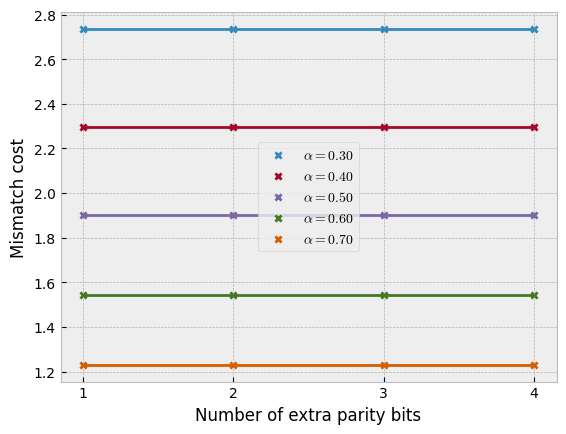

In [ ]:
p_in = [0.3, 0.4, 0.5, 0.6, 0.7]
i = 0
for p_in in [0.3, 0.4, 0.5, 0.6, 0.7]:
  plt.scatter(range(1, 5), np.array(MMC_channel).T[i], marker='x', s = 20, label = r'$\alpha = %0.2f$'%(p_in))
  plt.plot(range(1, 5), np.array(MMC_channel).T[i])
  i+=1

plt.xticks(range(1, 5))
plt.ticklabel_format(axis='y', style='plain')
plt.xlabel('Number of extra parity bits')
plt.ylabel('Mismatch cost')
plt.legend()

## 3.&nbsp; Error rate

### 2.1 &nbsp; Error: Increasing the parity bit

In [ ]:
ERROR = []
f = 0.001

MCd = []
cl = 0
for n in range(k+1, k+5):
  v2 = 2**np.arange(n)
  H = np.append(I, P[:n-k], axis = 0)
  G = np.append(P[:n-k].T, np.identity(n-k), axis = 0) #Syndrome Matrix

  messages = [(((i & (1 << np.arange(k)))) > 0).astype(int) for i in range(2**k)]
  encoded_messages = [H@x%2 for x in messages]
  ValidCodewords = np.array([np.dot(v2, m) for m in encoded_messages], dtype = int)
  nin_size = n+n-k
  M_f = M(f, n)
  Error = []
  Table = Tables[cl]
  cl += 1
  D_syn = np.zeros((2**n, 2**n))

  for i in range(2**n):
    y = (((i & (1 << np.arange(n)))) > 0).astype(int)
    s = G.T@y%2 #Calculating syndrome [Codeline 1: Matrix Multiplication]
    e_ = Table[tuple(s)] #look-up table [Codeline 2: Searching an element in the table]
    j = np.dot(2**np.arange(n), (y+e_)%2)
    D_syn[(i, j)] = 1

  for p in [0.3, 0.4, 0.5, 0.6, 0.7]:
    x = [p, 1-p]
    p_in = x
    for h in range(k-1):
      p_in = np.outer(p_in, x).flatten(order = 'F')
    p_in_encoder = p_in
    p_in_channel_messages = np.zeros(2**n)
    p_in_channel_messages[ValidCodewords] = p_in
    Error.append(1-np.dot(np.diag(M_f@D_syn), p_in_channel_messages))
  ERROR.append(Error)

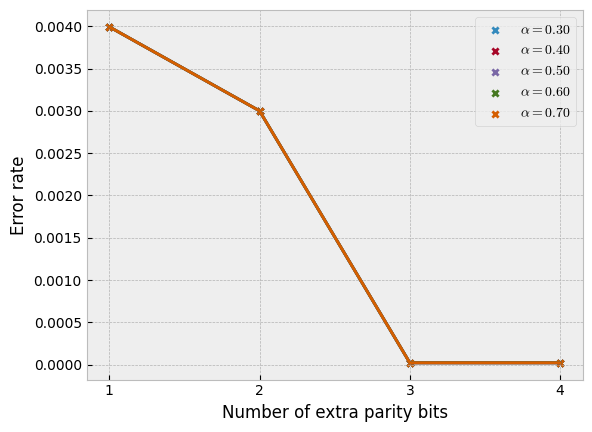

In [ ]:
plt.style.use('bmh')
p_in = [0.3, 0.4, 0.5, 0.6, 0.7]
i = 0
for p_in in [0.3, 0.4, 0.5, 0.6, 0.7]:
  plt.scatter(range(1, 5), np.array(ERROR).T[i], marker='x', s = 20, label = r'$\alpha = %0.2f$'%(p_in))
  plt.plot(range(1, 5), np.array(ERROR).T[i])
  i+=1


plt.xticks(range(1, 5))
plt.ticklabel_format(axis='y', style='plain')
plt.xlabel('Number of extra parity bits')
plt.ylabel('Error rate')
plt.legend()

### 2.2 &nbsp; Encoder+Decoder

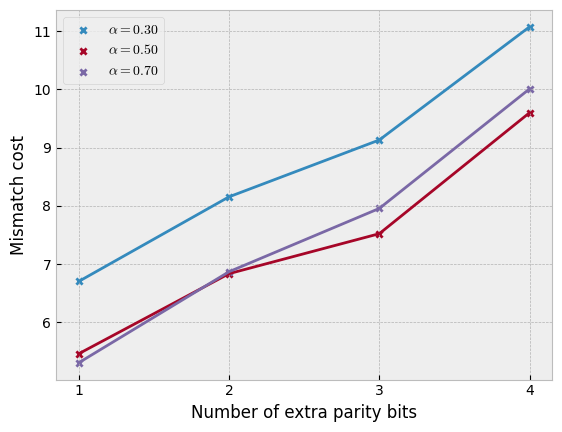

In [ ]:
p_in = [0.3, 0.4, 0.5, 0.6, 0.7]
i = 0
for p_in in [0.3, 0.5, 0.7]:
  plt.scatter(range(1, 5), np.array(MMC_channel).T[i]+np.array(MMCD).T[i]+np.array(MMC).T[i], marker='x', s = 20, label = r'$\alpha = %0.2f$'%(p_in))
  plt.plot(range(1, 5), np.array(MMC_channel).T[i]+np.array(MMCD).T[i]+np.array(MMC).T[i])
  i+=2

plt.xticks(range(1, 5))
plt.ticklabel_format(axis='y', style='plain')
plt.xlabel('Number of extra parity bits')
plt.ylabel('Mismatch cost')
plt.legend()

In [ ]:
ERROR = []
cl = 0
for n in range(k+1, k+5):
  v2 = 2**np.arange(n)
  H = np.append(I, P[:n-k], axis = 0)
  G = np.append(P[:n-k].T, np.identity(n-k), axis = 0)
  messages = [(((i & (1 << np.arange(k)))) > 0).astype(int) for i in range(2**k)]
  encoded_messages = [H@x%2 for x in messages]
  ValidCodewords = np.array([np.dot(v2, m) for m in encoded_messages], dtype = int)
  nin_size = n+n-k
  M_f = M(f, n)
  Error = []
  Table = Tables[cl]
  cl += 1
  D_syn = np.zeros((2**n, 2**n))

  for i in range(2**n):
    y = (((i & (1 << np.arange(n)))) > 0).astype(int)
    s = G.T@y%2 #Calculating syndrome [Codeline 1: Matrix Multiplication]
    e_ = Table[tuple(s)] #look-up table [Codeline 2: Searching an element in the table]
    j = np.dot(2**np.arange(n), (y+e_)%2)
    D_syn[(i, j)] = 1

  for p in [0.3, 0.4, 0.5, 0.6, 0.7]:
    x = [p, 1-p]
    p_in = x
    for h in range(k-1):
      p_in = np.outer(p_in, x).flatten(order = 'F')
    p_in_encoder = p_in
    p_in_channel_messages = np.zeros(2**n)
    p_in_channel_messages[ValidCodewords] = p_in
    Error.append(1-np.dot(np.diag(M_f@D_syn), p_in_channel_messages))
  ERROR.append(Error)

In [ ]:
p_in = [0.3, 0.4, 0.5, 0.6, 0.7]
i = 1
for p_in in [0.4]:
  plt.scatter(np.array(MMC_channel).T[i]+np.array(MMCD).T[i]+np.array(MMC).T[i], np.array(ERROR).T[i], marker='x', s = 20, label = r'$\alpha = %0.2f$'%(p_in))
  plt.plot(np.array(MMC_channel).T[i]+np.array(MMCD).T[i]+np.array(MMC).T[i], np.array(ERROR).T[i])
  i+=1

plt.ticklabel_format(axis='y', style="sci", scilimits=(0,0))
plt.ylabel('Block error rate')
plt.xlabel('Mismatch cost')
plt.legend()

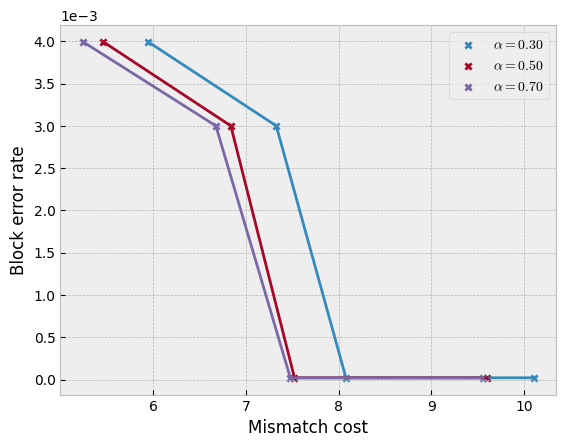

In [ ]:
p_in = [0.3, 0.4, 0.5, 0.6, 0.7]
i = 1
for p_in in [0.3, 0.5, 0.7]:
  plt.scatter(np.array(MMC_channel).T[i]+np.array(MMCD).T[i]+np.array(MMC).T[i], np.array(ERROR).T[i], marker='x', s = 20, label = r'$\alpha = %0.2f$'%(p_in))
  plt.plot(np.array(MMC_channel).T[i]+np.array(MMCD).T[i]+np.array(MMC).T[i], np.array(ERROR).T[i])
  i+=1

plt.ticklabel_format(axis='y', style="sci", scilimits=(0,0))
plt.ylabel('Block error rate')
plt.xlabel('Mismatch cost')
plt.legend()

In [ ]:
np.array(ERROR).T[1]

array([3.99400400e-03, 2.99999001e-03, 2.09301049e-05, 2.09301049e-05])

## 5.&nbsp; Changing the noise

In [ ]:
n = k+3

In [ ]:
def M(f, n):
  M_f =  np.zeros((2**(n), 2**(n)))
  for s1 in range(2**(n)):
    x = np.array((((s1 & (1 << np.arange(n)))) > 0).astype(int))
    for noise in range(2**(n)):
      noise = np.array((((noise & (1 << np.arange(n)))) > 0).astype(int))
      s2 = np.dot(2**np.arange(n), (x+noise)%2)
      M_f[(s1, s2)] = np.prod(f**noise)*np.prod((1-f)**(1-noise))
  return M_f


In [ ]:
#CONSTRUCTION OF LOOK UP TABLE for different encoding lenghts but same noise f = 0.01

Noises = [0.0001, 0.0005, 0.001, 0.005, 0.01]
Tables = []
G = np.append(P[:n-k].T, np.identity(n-k), axis = 0) #Syndrome Matrix
E_ = np.arange(0, 2**n)
E = np.array([(((v & (1 << np.arange(n)))) > 0).astype(int) for v in E_])
S = [G.T@y%2 for y in E]
for f in Noises:
  Table = dict()
  i = 0
  for e in E:
    if tuple(S[i]) in Table.keys():
      e = np.array(Table[tuple(S[i])])
      if np.prod((f**e)*(1-f)**(1-e)) < np.prod((f**E[i])*(1-f)**(1-E[i])):
        Table[tuple(S[i])] = E[i]
    else:
      Table[tuple(S[i])] = E[i]
    i+=1
  Tables.append(Table)

In [ ]:
DLN_n = []
AD2_n = []
AD3_n = []
COLMASKD_n = []

In [ ]:
bd = np.arange(4)+np.random.uniform(size = 4) #For unique hashing

v2 = 2**np.arange(n)
G = np.append(P[:n-k].T, np.identity(n-k), axis = 0) #Syndrome Matrix

szd = (2**n) * (2**(n-k)) * (2**n) * 4
uniquehash = np.zeros(szd, dtype=np.int64)

# Compute the hash values using broadcasting
hash_values = (np.arange(2**n)[:, None, None, None] * bd[0] +
              np.arange(2**(n-k))[None, :, None, None] * bd[1] +
              np.arange(2**n)[None, None, :, None] * bd[2] +
              np.arange(4)[None, None, None, :] * bd[3])

uniquehash = hash_values.flatten()

# Convert 'uniquehash' to a dictionary for faster lookup
uniquehash_dict = {hash_val: idx for idx, hash_val in enumerate(uniquehash)}

# Precompute the arrays that don't change within the inner loops
arrays_n = [((i & (1 << np.arange(n))) > 0).astype(int) for i in range(2**n)]
arrays_n_k = [((j & (1 << np.arange(n-k))) > 0).astype(int) for j in range(2**(n-k))]


j = 0
for f in Noises:

  Table = Tables[j]
  j += 1
  Ad = lil_matrix((szd, szd))
  # Main loop
  for i, y in enumerate(arrays_n):
      print('Loop', i)
      for s in arrays_n_k:
          for e in arrays_n:
              s0 = s
              y0 = y
              e0 = e

              cl = 0
              hvals= [(np.dot(v2,y0))*bd[0]+(np.dot(2**(np.arange(n-k)),s0))*bd[1]+(np.dot(v2,e0))*bd[2]+cl*bd[3]]

              s0 = G.T@y0%2 #Calculating syndrome
              cl = 1
              hvals.append((np.dot(v2,y0))*bd[0]+(np.dot(2**(np.arange(n-k)),s0))*bd[1]+(np.dot(v2,e0))*bd[2]+cl*bd[3])
              e0 = Table[tuple(s0)] #look-up table
              cl = 2
              hvals.append((np.dot(v2,y0))*bd[0]+(np.dot(2**(np.arange(n-k)),s0))*bd[1]+(np.dot(v2,e0))*bd[2]+cl*bd[3])

              y0 = (y0+e0)%2 #estimated output
              cl = 3
              hvals.append((np.dot(v2,y0))*bd[0]+(np.dot(2**(np.arange(n-k)),s0))*bd[1]+(np.dot(v2,e0))*bd[2]+cl*bd[3])
              #hvals = SYndromeDecoder_est(s, e, y)
              L = len(hvals)

              for u in range(L):
                  n1 = uniquehash_dict.get(hvals[u])
                  #if n1 is None:
                      #print('error')
                      #continue

                  if u < L - 1:
                      n2 = uniquehash_dict.get(hvals[u + 1])
                      #if n2 is None:
                          #print('error')
                          #continue
                  else:
                      n2 = n1

                  Ad[(n1, n2)] = 1

  Ad_csr = Ad.tocsr()
  row_mask = np.array(Ad.sum(axis=1) == 1).flatten()  #Compute the boolean mask for rows/columns with sum == 1
  indices = np.where(row_mask)[0]  #Convert the boolean mask to indices
  Ad2 = Ad_csr[indices, :][:, indices]  #Use the indices to create the submatrix and convert to dense array
  del Ad_csr
  del Ad
  #col_mask_d = np.asarray(Ad_csr.sum(axis=0) == 0).flatten() #indices of initial states
  #dln = len(Ad2)
  dln = Ad2.shape[0]
  col_mask_d = (Ad2.getnnz(axis=0) == 0).astype(bool)
  COLMASKD_n.append(col_mask_d)
  DLN_n.append(dln)
  AD2_n.append(Ad2)

Loop 0
Loop 1
Loop 2
Loop 3
Loop 4
Loop 5
Loop 6
Loop 7
Loop 8
Loop 9
Loop 10
Loop 11
Loop 12
Loop 13
Loop 14
Loop 15
Loop 16
Loop 17
Loop 18
Loop 19
Loop 20
Loop 21
Loop 22
Loop 23
Loop 24
Loop 25
Loop 26
Loop 27
Loop 28
Loop 29
Loop 30
Loop 31
Loop 32
Loop 33
Loop 34
Loop 35
Loop 36
Loop 37
Loop 38
Loop 39
Loop 40
Loop 41
Loop 42
Loop 43
Loop 44
Loop 45
Loop 46
Loop 47
Loop 48
Loop 49
Loop 50
Loop 51
Loop 52
Loop 53
Loop 54
Loop 55
Loop 56
Loop 57
Loop 58
Loop 59
Loop 60
Loop 61
Loop 62
Loop 63
Loop 64
Loop 65
Loop 66
Loop 67
Loop 68
Loop 69
Loop 70
Loop 71
Loop 72
Loop 73
Loop 74
Loop 75
Loop 76
Loop 77
Loop 78
Loop 79
Loop 80
Loop 81
Loop 82
Loop 83
Loop 84
Loop 85
Loop 86
Loop 87
Loop 88
Loop 89
Loop 90
Loop 91
Loop 92
Loop 93
Loop 94
Loop 95
Loop 96
Loop 97
Loop 98
Loop 99
Loop 100
Loop 101
Loop 102
Loop 103
Loop 104
Loop 105
Loop 106
Loop 107
Loop 108
Loop 109
Loop 110
Loop 111
Loop 112
Loop 113
Loop 114
Loop 115
Loop 116
Loop 117
Loop 118
Loop 119
Loop 120
Loop 121
Loop 122
Loo

In [ ]:
AD3_n = []
G = np.append(P[:n-k].T, np.identity(n-k), axis = 0)
state_len = n+n+n-k

for f in Noises:
  j = 0
  Table = Tables[j]
  j += 1
  Ad3 = lil_matrix((2**state_len, 2**state_len))
  for n1 in range(2**state_len):
    x = ((n1 & (1 << np.arange(state_len))) > 0).astype(int)
    x[n:n+n-k] = G.T@x[:n]%2 #Calculating syndrome [Codeline 1: Matrix Multiplication]
    x[n+n-k:] = Table[tuple(x[n:n+n-k])] #look-up table [Codeline 2: Searching an element in the table]
    x[:n] = (np.array(x[:n])+np.array(x[n+n-k:]))%2 #estimated output [Codeline 3]
    n2 = np.dot(2**np.arange(state_len), x)
    #print(n1, n2)
    Ad3[(n1, n2)] = 1
  AD3_n.append(Ad3)

In [ ]:
i = 0
f = 0.001
v2 = 2**np.arange(n)
H = np.append(I, P[:n-k], axis = 0)
messages = [(((i & (1 << np.arange(k)))) > 0).astype(int) for i in range(2**k)]
encoded_messages = [H@x%2 for x in messages]
ValidCodewords = np.array([np.dot(v2, m) for m in encoded_messages], dtype = int)
nin_size = n+n-k
MMCD_n = []

for f in Noises:
  M_f = M(f, n)

  MCd = []
  dln = DLN_n[i]
  Ad2 = AD2_n[i]
  Ad3 = AD3_n[i]
  col_mask_d = COLMASKD_n[i]
  i += 1
  #alpha = 0.5
  #q0_e = np.random.dirichlet(alpha*np.ones(eln))   #random prior
  q0_d = 1/dln*np.ones(dln)                       #uniform prior
  q1 = Ad2.T@q0_d
  for p in [0.3, 0.4, 0.5, 0.6, 0.7]:
    x = [p, 1-p]
    p_in = x
    for h in range(k-1):
      p_in = np.outer(p_in, x).flatten(order = 'F')
    p_in_encoder = p_in
    p_in_channel_messages = np.zeros(2**n)
    p_in_channel_messages[ValidCodewords] = p_in
    p_out_channel_messages = M_f.T@p_in_channel_messages
    p_tnin_decoder = (1/2**nin_size)*np.ones(2**nin_size)


    PMCdi = 0
    p0 = np.zeros(dln)
    p_joint = Ad3.T@np.outer(p_out_channel_messages, p_tnin_decoder).flatten(order = 'F')
    p_marg_nin = np.sum(p_joint.reshape((2**n, 2**(n+n-k))), axis = 0)
    p0[col_mask_d] = np.outer(p_out_channel_messages, p_marg_nin).flatten(order = 'F')

    for r in range(3):
      p1 = Ad2.T@p0
      PMCdi += np.sum(rel_entr(p0, q0_d))-np.sum(rel_entr(p1, q1))
      p0 = p1

    MCd.append(PMCdi)



  MMCD_n.append(np.array(MCd).T)

7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7


Text(0, 0.5, 'Mismatch cost')

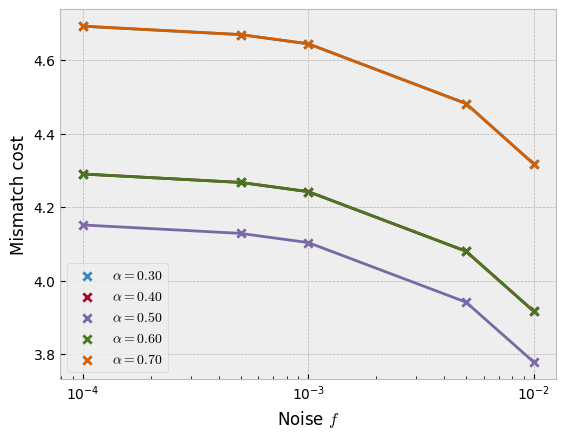

In [ ]:
p_in = [0.3, 0.4, 0.5, 0.6, 0.7]
for i in range(len(MMCD_n)):
  plt.scatter(Noises, np.array(MMCD_n).T[i], marker = 'x', label = r'$\alpha = %0.2f$'%(p_in[i]))
  plt.plot(Noises, np.array(MMCD_n).T[i])
plt.legend()
plt.xscale('log')
plt.xlabel(r'Noise $f$')
plt.ylabel('Mismatch cost')

Text(0, 0.5, 'Mismatch cost')

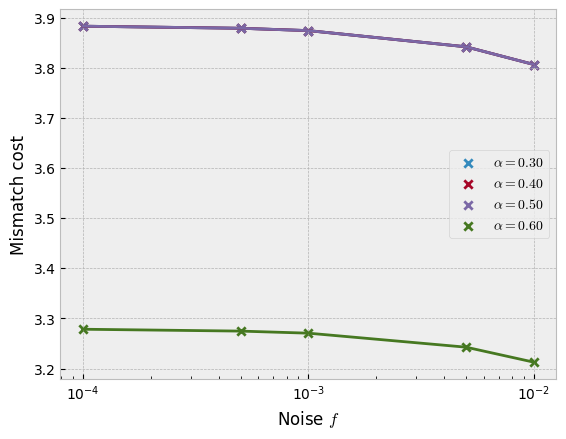

In [ ]:
p_in = [0.3, 0.4, 0.5, 0.6, 0.7]
for i in [0, 1, 2, 3]:
  plt.scatter(Noises, np.array(MC_channel_noise).T[i], marker = 'x', label = r'$\alpha = %0.2f$'%(p_in[i]))
  plt.plot(Noises, np.array(MC_channel_noise).T[i])
plt.legend()
plt.xscale('log')
plt.xlabel(r'Noise $f$')
plt.ylabel('Mismatch cost')

### 5.2 &nbsp; Error: Changing the noise

In [ ]:
ERROR = []
cl = 0
v2 = 2**np.arange(n)
H = np.append(I, P[:n-k], axis = 0)
G = np.append(P[:n-k].T, np.identity(n-k), axis = 0)
messages = [(((i & (1 << np.arange(k)))) > 0).astype(int) for i in range(2**k)]
encoded_messages = [H@x%2 for x in messages]
ValidCodewords = np.array([np.dot(v2, m) for m in encoded_messages], dtype = int)

nin_size = n+n-k
for f in Noises:
  M_f = M(f, n)
  Error = []
  Table = Tables[cl]
  cl += 1
  D_syn = np.zeros((2**n, 2**n))

  for i in range(2**n):
    y = (((i & (1 << np.arange(n)))) > 0).astype(int)
    s = G.T@y%2 #Calculating syndrome [Codeline 1: Matrix Multiplication]
    e_ = Table[tuple(s)] #look-up table [Codeline 2: Searching an element in the table]
    j = np.dot(2**np.arange(n), (y+e_)%2)
    D_syn[(i, j)] = 1

  for p in [0.3, 0.4, 0.5, 0.6, 0.7]:
    x = [p, 1-p]
    p_in = x
    for h in range(k-1):
      p_in = np.outer(p_in, x).flatten(order = 'F')
    p_in_encoder = p_in
    p_in_channel_messages = np.zeros(2**n)
    p_in_channel_messages[ValidCodewords] = p_in
    Error.append(1-np.dot(np.diag(M_f@D_syn), p_in_channel_messages))
  ERROR.append(Error)

Text(0, 0.5, 'Mismatch Cost')

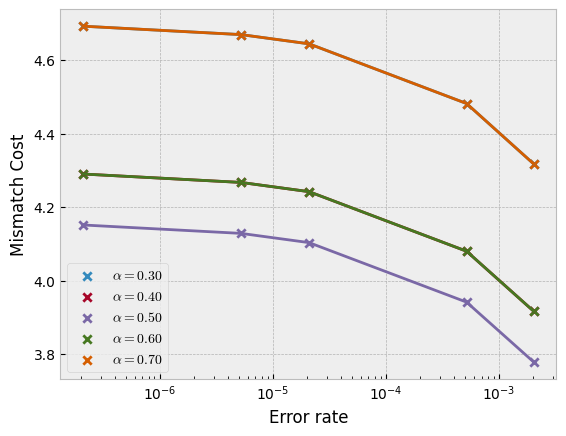

In [ ]:
p_in = [0.3, 0.4, 0.5, 0.6, 0.7]
for i in range(len(ERROR)):
  plt.scatter(np.array(ERROR).T[i], np.array(MMCD_n).T[i], marker = 'x', label = r'$\alpha = %0.2f$'%(p_in[i]))
  plt.plot(np.array(ERROR).T[i], np.array(MMCD_n).T[i])
plt.legend()
plt.xscale('log')
plt.xlabel('Error rate')
plt.ylabel('Mismatch Cost')